In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, InputLayer, Flatten, Dropout, Conv2DTranspose, UpSampling2D, BatchNormalization, \
GlobalAveragePooling2D, Input, Activation, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adamax, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50V2, InceptionV3, resnet_v2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import load_img, img_to_array, image_dataset_from_directory

from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1f4hp_kPzdOGDCcfaZg1NkZ3oAvIFaqH_&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1f4hp_kPzdOGDCcfaZg1NkZ3oAvIFaqH_
To: /content/UTKFace.zip
100% 120M/120M [00:02<00:00, 59.2MB/s]


In [ ]:
#!mkdir 'UTKFace'
!unzip -q 'UTKFace.zip'

replace UTKFace/1_0_0_20161219140623097.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!mkdir 'data'
!cp '/content/drive/MyDrive/UTKFace/UTKFace.zip' 'data/data.zip'
!unzip -q 'data/data.zip'

# Data visualization

In [ ]:
import os
import seaborn as sns
import cv2
import numpy as np
import pandas as pd
path = '/content/UTKFace'

files = os.listdir(path)

ages = []
age_group = []
genders = []
labels = []
for file in files:
    temp = file.split('_')
    age = int(temp[0])
    ages.append(age)
    genders.append(int(temp[1]))

    age = age // 15
    if age > 4:
        age = 4
    age_group.append(age)

    t = [0] * 6

In [ ]:
genders.count(1)

In [ ]:
genders = np.array(genders, dtype=int)

<Axes: >

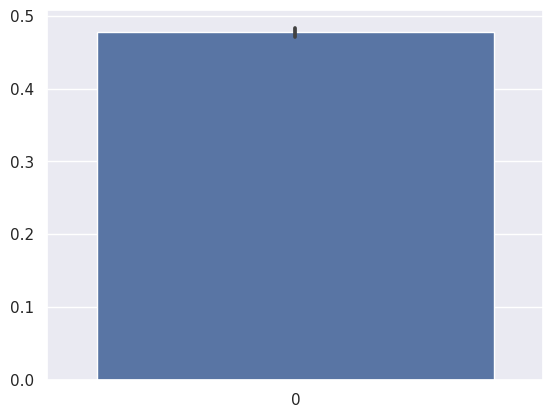

In [ ]:
genders

AttributeError: ignored

In [ ]:
genders_string = ["Male" if gen == 0 else "Female" for gen in genders]

<Axes: ylabel='count'>

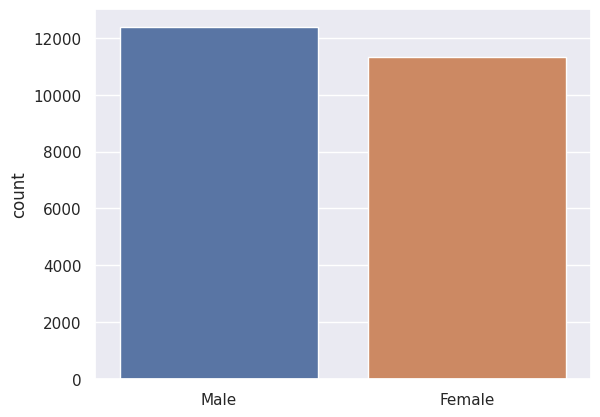

In [ ]:
sns.set_theme()
sns.countplot(x=genders_string)

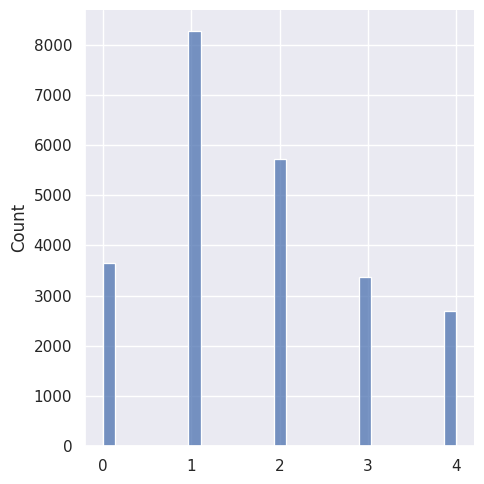

In [ ]:
sns.set_theme()
sns.displot(age_group)

In [ ]:
sns.set_theme()
sns.barplot(x=[0, 1, 2, 3, 4], y=[1, 2, 3, 4])

ValueError: ignored

# Data pre-processing

In [ ]:
import os
import cv2

path = '/content/UTKFace'
files = np.array(os.listdir(path))
#np.random.shuffle(files)
#batch_half = files[: len(files) // 2]

#idf = image_dataset_from_directory(path, labels= None)

In [ ]:

def imageLoader(files, batch_size = 32, isEvaluate = False):

    L = len(files)

    #this line is just to make the generator infinite, keras needs that
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            Y = []
            X = []
            imgs = []
            for f in files[batch_start: batch_end]:
                y = [0]*6
                img = cv2.imread(path + '/' + f, cv2.IMREAD_COLOR)
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))
                #img = load_img(path + "/" + f)
                imgs.append(np.array(img, dtype = np.float32) / 255)

                temp = f.split('_')
                y[0] = int(temp[1])
                idx = int(temp[0]) // 15
                if idx > 4:
                  idx = 4
                y[idx + 1] = 1

                Y.append(y)
            X = np.array(imgs, dtype=np.float32)
            Y = np.array(Y, dtype = np.float32)

            yield (X, Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size
        if isEvaluate:
          break

In [ ]:

def imageLoader2(files, batch_size = 32, isEvaluate = False):

    L = len(files)

    #this line is just to make the generator infinite, keras needs that
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            Y = []
            X = []
            imgs = []
            for f in files[batch_start: batch_end]:
                y = [0]*6
                img = cv2.imread(path + '/' + f, cv2.IMREAD_COLOR)
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))
                #img = load_img(path + "/" + f)
                imgs.append(np.array(img, dtype = np.float32) / 255)

                temp = f.split('_')
                y[0] = int(temp[1])
                idx = int(temp[0]) // 15
                if idx > 4:
                  idx = 4
                y[idx + 1] = 1

                Y.append(y)
            X = np.array(imgs, dtype=np.float32)
            Y = np.array(Y, dtype = np.float32)

            yield (X,[ Y[:,0], Y[:, 1:] ]) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size
        if isEvaluate:
          break

In [ ]:

def testLoader(files, batch_size = 32, isEvaluate = False):
    L = len(files)
    #this line is just to make the generator infinite, keras needs that
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = []
            imgs = []
            for f in files[batch_start: batch_end]:
                #print(f)
                img = cv2.imread('UTKFace/' + f, cv2.IMREAD_COLOR)
                #print(type(img))
                img = np.array(img, dtype=np.float32) / 255
                #print(img.shape)

                img = cv2.resize(img, (128, 128))
                #print(img.shape)
                #img = img.reshape(1, 128, 128, 3)
                imgs.append(np.array(img, dtype=np.float32) )

            X = np.array(imgs, dtype=np.float32)
            yield (X)
            batch_start += batch_size
            batch_end += batch_size
        if isEvaluate:
          break

In [ ]:
# Y_labels = []

# for f in files:
#     y = [0]*5

#     temp = f.split('_')
#     #y[0] = int(temp[1])
#     idx = int(temp[0]) // 15
#     if idx > 4:
#       idx = 4
#     y[idx] = 1
#     y = idx
#     Y_labels.append(y)

# #Y_labels = np.array(Y_labels)

In [ ]:
files_train, files_test = train_test_split(files, test_size=0.2, shuffle = True, random_state = 7)

# multi-output model

In [ ]:
def block(input_tensor, conv_filters, conv_size, stride):

    x = Conv2D(conv_filters, conv_size, padding = 'same', strides=stride)(input_tensor)
    x = Activation('relu')(x)
    x = BatchNormalization(input_shape=input_tensor.shape[1:]) (x)
    x = MaxPooling2D((2, 2), 2) (x)
    x = Dropout(rate=0.25) (x)

    return x

input = Input(shape = (128, 128, 3))

block1 = block(input, 96, (5, 5), 2)
block2 = block(block1, 96, (3, 3), 1)
block3 = block(block2, 256, (3, 3), 1)
block4 = block(block3, 512, (3, 3), 1)
block5 = block(block4, 512, (3, 3), 1)

bottle_neck2 = GlobalAveragePooling2D() (block5)
bottle_neck = GlobalMaxPooling2D() (block4)
#bottle_neck = Flatten() (block4)

gender_model = Dense(256, activation='relu') (bottle_neck)
gender_model = Dropout(0.5) (gender_model)
gender_model = Dense(1, activation='sigmoid', name='gender_out') (gender_model)

age_model = Dense(512, activation='relu') (bottle_neck2)
age_model = Dropout(0.5) (age_model)
age_model = Dense(5, activation='softmax', name='age_out') (age_model)

model = Model(inputs=input, outputs=[gender_model, age_model])

# multi-label model

In [ ]:
def sub_block(shape):
  return Sequential([
    BatchNormalization(input_shape = shape),
    MaxPool2D((2, 2), 2),
    Dropout(rate=0.25)
])

def create_model():
    input = Input((128, 128, 3))
    block1 = Sequential([
        InputLayer(input_shape = (128, 128, 3)),
        Conv2D(96, (5, 5), (2, 2), padding='same', activation=relu),
        sub_block((64, 64, 96))
    ])

    block2 = Sequential([
        InputLayer(input_shape = (32, 32, 96)),
        Conv2D(96, (3, 3), (1, 1), padding='same', activation=relu),
        sub_block((32, 32, 96))
    ])

    block3 = Sequential([
        InputLayer(input_shape = (16, 16, 96)),
        Conv2D(256, (3, 3), (1, 1), padding='same', activation=relu),
        #Dropout(rate=0.25),
        sub_block((16, 16, 256))
    ])

    block4 = Sequential([
        InputLayer(input_shape = (8, 8, 256)),
        Conv2D(512, (3, 3), (1, 1), padding='same', activation=relu),
        sub_block((8, 8, 512))
    ])
    block5 = Sequential([
        InputLayer(input_shape = (4, 4, 512)),
        Conv2D(512, (3, 3), (1, 1), padding='same', activation=relu),
        sub_block((4, 4, 512))
    ])

    # gender_model = Sequential([
    #     InputLayer(input_shape=(256)),
    #     Dense(128, activation='leaky_relu'),
    #     # BatchNormalization(),
    #     Dropout(rate=0.5),
    #     Dense(1, activation=sigmoid)
    # ])

    # age_model = Sequential([
    #     InputLayer(input_shape=(256)),
    #     Dense(256, activation='leaky_relu'),
    #     # BatchNormalization(),
    #     Dropout(rate=0.5),
    #     Dense(1, activation=softmax)
    # ])
    # feature_extractor = Sequential([
    #     block1,
    #     block2,
    #     block3,
    #     block4,
    #     #Flatten(),
    #     GlobalAveragePooling2D()
    # ])
    # f = feature_extractor(input)
    # model = Model(inputs=[input], outputs=[gender_model, age_model])
    model = Sequential([
        block1,
        block2,
        block3,
        block4,
        block5,
        #Flatten(),
        GlobalAveragePooling2D(),
        #GlobalMaxPooling2D(),
        Dense(512, activation='relu'),
        #BatchNormalization(),
        Dropout(rate=0.5),
        Dense(6, activation=sigmoid)
    ])
    return model

In [ ]:
model = create_model()

# resnet

In [ ]:
resnet = ResNet50V2(include_top=False, input_shape=(128, 128, 3))
resnet.trainable = True

In [ ]:
resnet.summary()

In [ ]:
model = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    #Flatten(),
    Dense(256, activation='leaky_relu', kernel_regularizer=l2()),
    Dropout(rate=0.4),
    Dense(6, activation='sigmoid')

])

model.compile(optimizer = 'adam', loss =binary_crossentropy,metrics=['accuracy'])

# Training


In [ ]:
import keras
model = keras.models.load_model("cnn_1_output.h5")

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', classes=np.unique(Y_labels), y=Y_labels)

In [ ]:
#For 2 output model
model.compile(optimizer = AdamW(), loss =['binary_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy'],
              loss_weights={'gender_out': 1., 'age_out' : 2.},
              )
model.summary()

In [ ]:
#For multi label model
model.compile(optimizer=AdamW(),
              loss=binary_crossentropy,
              #loss_weights=[2, 1, 0.5, 0.75, 1, 1],
              metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None, 128, 128, 3))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 32, 32, 96)        7680      
                                                                 
 sequential_14 (Sequential)  (None, 16, 16, 96)        83424     
                                                                 
 sequential_16 (Sequential)  (None, 8, 8, 256)         222464    
                                                                 
 sequential_18 (Sequential)  (None, 4, 4, 512)         1182208   
                                                                 
 sequential_20 (Sequential)  (None, 2, 2, 512)         2361856   
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                     

In [ ]:
w = {0: 1, 1: 1.29871268, 2: 0.57224234, 3: 0.82924099, 4: 1.40993161, 5: 1.76267658}

In [ ]:
model.fit(imageLoader(files_train, 32),
          steps_per_epoch=128,
          epochs = 100,
          class_weight=w,
          shuffle=False,
          #validation_data=imageLoader2(files_test),
          #validation_steps = 1#len(files_test) // 32
          )

Epoch 1/100
128/128 [==============================] - 13s 71ms/step - loss: 0.5737 - accuracy: 0.3799
Epoch 2/100
128/128 [==============================] - 5s 39ms/step - loss: 0.4735 - accuracy: 0.4663
Epoch 3/100
128/128 [==============================] - 6s 48ms/step - loss: 0.4173 - accuracy: 0.5283
Epoch 4/100
128/128 [==============================] - 5s 37ms/step - loss: 0.3957 - accuracy: 0.5347
Epoch 5/100
128/128 [==============================] - 5s 38ms/step - loss: 0.3710 - accuracy: 0.5573
Epoch 6/100
128/128 [==============================] - 6s 47ms/step - loss: 0.3636 - accuracy: 0.5767
Epoch 7/100
128/128 [==============================] - 5s 37ms/step - loss: 0.3610 - accuracy: 0.5959
Epoch 8/100
128/128 [==============================] - 6s 47ms/step - loss: 0.3377 - accuracy: 0.6001
Epoch 9/100
128/128 [==============================] - 5s 38ms/step - loss: 0.3440 - accuracy: 0.5952
Epoch 10/100
128/128 [==============================] - 5s 37ms/step - loss: 0.32

In [ ]:
init_weights = model.get_weights()

In [ ]:
kfold = KFold(n_splits = 5)

histories = []

for train_idx, val_idx in kfold.split(X=files_train):
  model.set_weights(init_weights)

  history = model.fit(imageLoader2(files_train[train_idx], 32), batch_size = 32, steps_per_epoch=128, epochs = 50,
                      validation_data=imageLoader2(files_train[val_idx]),
                      validation_steps = len(files_train[val_idx]) // 32,
                      shuffle = False

                      )
  histories.append(history)


In [ ]:
model.evaluate_generator(imageLoader(files_test, 1, True))

<ipython-input-55-70082c4eded7>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(imageLoader(files_test, 1, True))


[0.37539342045783997, 0.6619569659233093]

# cam code

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:

haar_file = '/content/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_file)
age_group = {0: '0 - 15',
             1: '16 - 30',
             2: '31 - 45',
             3: '46 - 60',
             4: 'Over60'
             }
font = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10, 500)
fontScale = 0.5
fontColor = (255, 255, 255)
thickness = 1
lineType = 2

def inference2(frame, isFace = False, display=True):
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 4)
  # Display the resulting frame
  if not isFace:
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        # print(frame.shape)
        temp = frame[y: y + h, x: x + w]
        temp = cv2.resize(temp, (128, 128))
        #print(temp.shape)
        predict = model.predict(temp.reshape(1, 128, 128, 3), verbose=False)
        #print(predict)
        gender = "Female" if predict[0][0] > 0.5 else "Male"
        age = np.argmax(predict[1][0])
        #print("gender: ", gender, " age group: ", age)
        cv2.putText(frame, f"Gender: {gender}, Age: {age_group[age]}",
                    (x, y - 10),
                    font,
                    fontScale,
                    fontColor,
                    thickness,
                    lineType)
  else:
    plt.imshow(frame)
    temp = cv2.resize(frame, (128, 128))
    #print(temp.shape)
    predict = model.predict(temp.reshape(1, 128, 128, 3), verbose=False)
    #print(predict)
    gender = "Female" if predict[0][0] > 0.5 else "Male"
    age = np.argmax(predict[1][0])
    #print("gender: ", gender, " age group: ", age)
    print( f"Gender: {gender}, Age: {age_group[age]}")
  if display:
    plt.imshow(frame)


def inference(frame, isFace = False, display=True):
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 4)
  # Display the resulting frame
  if not isFace:
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        # print(frame.shape)
        temp = frame[y: y + h, x: x + w]
        temp = cv2.resize(temp, (128, 128))
        #print(temp.shape)
        predict = model.predict(temp.reshape(1, 128, 128, 3), verbose=False)[0]
        #print(predict)
        gender = "Female" if predict[0] > 0.5 else "Male"
        age = np.argmax(predict[1:])
        #print("gender: ", gender, " age group: ", age)
        cv2.putText(frame, f"Gender: {gender}, Age: {age_group[age]}",
                    (x, y - 10),
                    font,
                    fontScale,
                    fontColor,
                    thickness,
                    lineType)
  else:
    plt.imshow(frame)
    temp = cv2.resize(frame, (128, 128))
    #print(temp.shape)
    predict = model.predict(temp.reshape(1, 128, 128, 3), verbose=False)[0]
    #print(predict)
    gender = "Female" if predict[0] > 0.5 else "Male"
    age = np.argmax(predict[1:])
    #print("gender: ", gender, " age group: ", age)
    print( f"Gender: {gender}, Age: {age_group[age]}")
  if display:
    plt.imshow(frame)



# test model

In [ ]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

[0.0000000e+00 1.0000000e+00 2.5700856e-30 0.0000000e+00 0.0000000e+00
 1.0000000e+00]


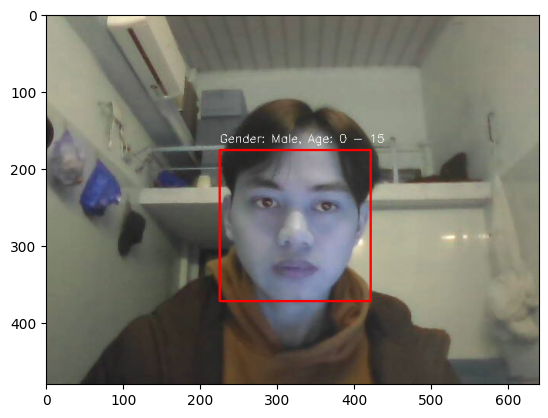

In [ ]:
path_img = 'photo.jpg'
img = cv2.imread(path_img, cv2.IMREAD_COLOR)
inference(img)

In [ ]:
for f in files[:100]:
  img = cv2.imread("UTKFace/" + f, cv2.IMREAD_COLOR)
  print(f)
  inference(img, True, False)
  #input("Enter to continue")

In [ ]:
model.summary()

In [ ]:
model.save("cnn_1_output_v2-100epoch.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
preds = model.predict_generator(testLoader(files_test, 1, True))


<ipython-input-56-0ec7c7a96333>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(testLoader(files_test, 1, True))


In [ ]:
y_pred = []
if len(preds) == 2:
  results = np.column_stack((preds[0], preds[1]))
else:
  results = preds
#for y in np.column_stack((preds[0], preds[1])):
#for y in preds:
for y in results:
    temp = [0] * 6
    temp[0] = 1 if y[0] > 0.5 else 0
    #print(y)
    ix = np.argmax(y[1:])
    #print(y)
    temp[ix + 1] = 1
    y_pred.append(temp)

In [ ]:
y_test = []
breakpoints = [15, 30, 45, 60]
for f in files_test:
#for f in files_train:
    y = [0] * 6
    temp = f.split("_")
    y[0] = int(temp[1])
    a = int(temp[0])
    ix = len(breakpoints)
    for i, b in enumerate(breakpoints):
        if a < b:
            ix = i
            break
    y[ix + 1] = 1
    y_test.append(y)

In [ ]:
files_train.shape

In [ ]:
with open("test.txt", "w") as f:
  for l in np.column_stack((files_test, y_pred)):
    f.write(" ".join(l))
    f.write("\n")

In [ ]:
y_test = np.array(y_test)
y_pred = np.array(y_pred)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_recall_fscore_support

acc_gender = accuracy_score(y_test[:, 0], y_pred[:, 0])
acc_age = accuracy_score(y_test[:, 1:], y_pred[:, 1:])
matrix = multilabel_confusion_matrix(y_test, y_pred)
cr_age = classification_report(y_test[:, 1:], y_pred[:, 1:])
cr_gen = classification_report(y_test[:, 0], y_pred[:, 0])
prf_age = precision_recall_fscore_support(y_test[:, 1:], y_pred[:, 1:], average='micro')
prf_gen = precision_recall_fscore_support(y_test[:, 0], y_pred[:, 0], average='micro')

In [ ]:
acc_gender, acc_age

(0.9008857022353437, 0.6465626318009279)

In [ ]:
print(prf_gen)
print(prf_age)

(0.9008857022353437, 0.9008857022353437, 0.9008857022353437, None)
(0.6465626318009279, 0.6465626318009279, 0.6465626318009279, None)


In [ ]:
print(cr_gen)
print(cr_age)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2474
           1       0.93      0.86      0.89      2268

    accuracy                           0.90      4742
   macro avg       0.90      0.90      0.90      4742
weighted avg       0.90      0.90      0.90      4742

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       738
           1       0.67      0.76      0.72      1639
           2       0.50      0.44      0.47      1150
           3       0.49      0.37      0.42       673
           4       0.66      0.73      0.69       542

   micro avg       0.65      0.65      0.65      4742
   macro avg       0.64      0.64      0.64      4742
weighted avg       0.64      0.65      0.64      4742
 samples avg       0.65      0.65      0.65      4742



In [ ]:
y_pred_count = np.array([0] * 6)
for y in y_pred:
  y_pred_count += y

y_test_count = np.array([0] * 6)
for y in y_test:
  y_test_count += y

In [ ]:
y_pred_count, y_test_count

(array([2092,  749, 1853, 1030,  509,  601]),
 array([2268,  738, 1639, 1150,  673,  542]))

<Axes: ylabel='Count'>

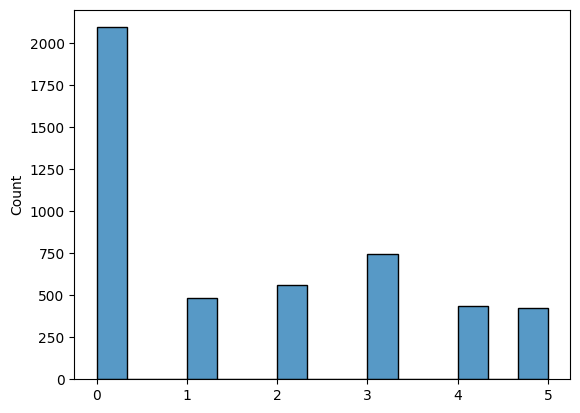

In [ ]:
import seaborn as sns
y_pred_labels = [np.argmax(y) for y in y_pred]
sns.histplot(y_pred_labels)

In [ ]:
y_pred_labels

In [ ]:
matrix

array([[[2208,  278],
        [1118, 1138]],

       [[3758,  234],
        [ 384,  366]],

       [[ 737, 2379],
        [  94, 1532]],

       [[3441,  166],
        [1092,   43]],

       [[4053,   11],
        [ 678,    0]],

       [[4188,    1],
        [ 543,   10]]])

In [ ]:
history = histories[0]
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [ ]:
histories[0].history

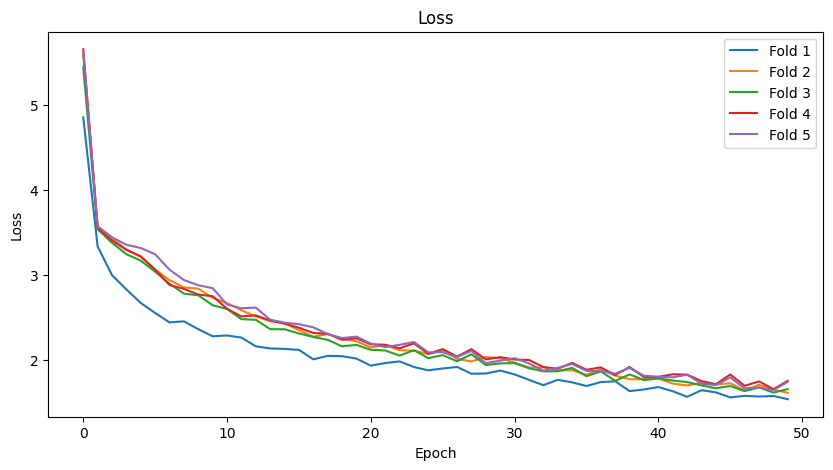

In [ ]:
plt.figure(figsize = (10, 5))
for i in range(5):
  #plt.subplot(2, 5, i + 1)
  history = histories[i]
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5',], loc='upper right')


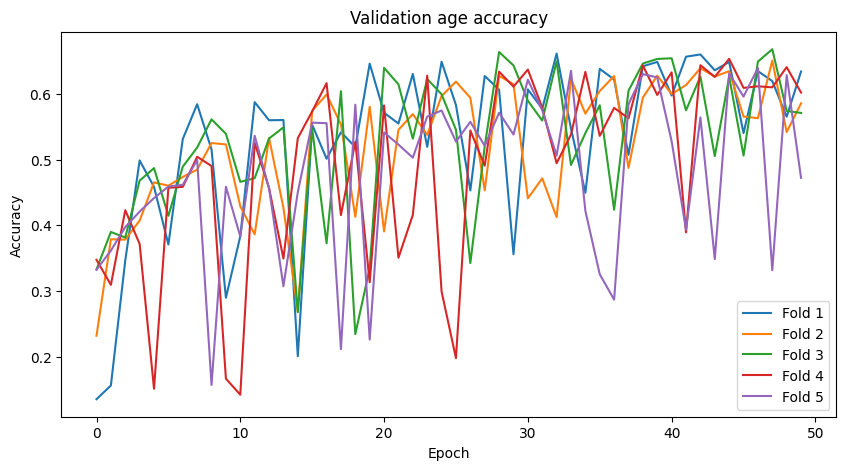

In [ ]:
plt.figure(figsize = (10, 5))
for i in range(5):
  #plt.subplot(2, 5, i + 1)
  history = histories[i]
  #plt.plot(history.history['age_out_accuracy'])
  plt.plot(history.history['val_age_out_accuracy'])
  plt.title('Validation age accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5',], loc='lower right')